# Machine Learning Surrogate Model Training

This notebook trains machine learning models as surrogate models for fast option pricing and volatility prediction.

## Objectives
1. Prepare training datasets from Black-Scholes and Heston results
2. Engineer features for ML models
3. Train multiple ML models (Random Forest, SVM, Neural Networks)
4. Optimize hyperparameters
5. Evaluate and compare model performance
6. Create fast pricing surrogates

In [18]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Install required packages if not available
try:
    from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.svm import SVR
    from sklearn.neural_network import MLPRegressor
    from sklearn.preprocessing import StandardScaler, RobustScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.pipeline import Pipeline
    import joblib
    print("✅ All ML libraries imported successfully!")
except ImportError as e:
    print(f"❌ Missing packages. Installing required ML libraries...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn', 'joblib'])
    
    # Try importing again
    from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.svm import SVR
    from sklearn.neural_network import MLPRegressor
    from sklearn.preprocessing import StandardScaler, RobustScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.pipeline import Pipeline
    import joblib
    print("✅ ML libraries installed and imported successfully!")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries loaded successfully!")

✅ All ML libraries imported successfully!
All libraries loaded successfully!


## 1. Load Previous Results and Prepare Data

In [3]:
# Load previous results and market data
results_dir = Path('../outputs/results')
data_dir = Path('../data')

# Load Black-Scholes baseline results
bs_results = pd.read_csv(results_dir / 'black_scholes_baseline_results.csv')
print(f"Loaded Black-Scholes results: {len(bs_results)} rows")

# Try to load Heston results if available
try:
    heston_results = pd.read_csv(results_dir / 'heston_model_results.csv')
    print(f"Loaded Heston results: {len(heston_results)} rows")
    heston_available = True
except FileNotFoundError:
    print("⚠️  Heston results not found. Will use Black-Scholes data only.")
    heston_available = False

# Load market data directly
equity_data = pd.read_csv(data_dir / 'raw' / 'equities' / 'combined_equities.csv')
equity_data['Date'] = pd.to_datetime(equity_data['Date'])

treasury_data = pd.read_csv(data_dir / 'external' / 'treasury_yields.csv')
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

options_data = pd.read_csv(data_dir / 'raw' / 'options' / 'spy_options.csv')
options_data['Date'] = pd.to_datetime(options_data['Date'])
options_data['Expiration'] = pd.to_datetime(options_data['Expiration'])

# Get current market parameters
spy_data = equity_data[equity_data['Symbol'] == 'SPY'].copy()
current_price = spy_data['Close'].iloc[-1]
treasury_current = treasury_data.iloc[-1]
risk_free_rate = treasury_current['DGS3MO'] / 100

print(f"\nMarket parameters:")
print(f"  - SPY price: ${current_price:.2f}")
print(f"  - Risk-free rate: {risk_free_rate:.4f} ({risk_free_rate*100:.2f}%)")
print(f"  - Data loaded successfully!")

Loaded Black-Scholes results: 704 rows
Loaded Heston results: 0 rows

Market parameters:
  - SPY price: $793.41
  - Risk-free rate: 0.0089 (0.89%)
  - Data loaded successfully!


## 2. Feature Engineering

In [4]:
def create_ml_features(data, underlying_price, risk_free_rate):
    """Create comprehensive feature set for ML models"""
    
    features_df = data.copy()
    
    # Basic features
    features_df['S'] = underlying_price
    features_df['r'] = risk_free_rate
    features_df['K'] = features_df['Strike']
    features_df['T'] = features_df['Time_to_Expiry']
    
    # Moneyness features
    features_df['moneyness'] = underlying_price / features_df['Strike']
    features_df['log_moneyness'] = np.log(features_df['moneyness'])
    features_df['moneyness_squared'] = features_df['moneyness'] ** 2
    
    # Time features
    features_df['sqrt_time'] = np.sqrt(features_df['T'])
    features_df['time_squared'] = features_df['T'] ** 2
    features_df['days_to_expiry'] = features_df['DTE']
    features_df['weeks_to_expiry'] = features_df['DTE'] / 7
    
    # Option type encoding
    features_df['is_call'] = (features_df['Type'] == 'C').astype(int)
    features_df['is_put'] = (features_df['Type'] == 'P').astype(int)
    
    # Intrinsic value
    features_df['intrinsic_call'] = np.maximum(underlying_price - features_df['Strike'], 0)
    features_df['intrinsic_put'] = np.maximum(features_df['Strike'] - underlying_price, 0)
    features_df['intrinsic_value'] = (features_df['is_call'] * features_df['intrinsic_call'] + 
                                     features_df['is_put'] * features_df['intrinsic_put'])
    
    # Forward price
    features_df['forward_price'] = underlying_price * np.exp(risk_free_rate * features_df['T'])
    features_df['forward_moneyness'] = features_df['forward_price'] / features_df['Strike']
    
    # Interaction features
    features_df['moneyness_time'] = features_df['moneyness'] * features_df['T']
    features_df['log_moneyness_time'] = features_df['log_moneyness'] * features_df['T']
    features_df['moneyness_sqrt_time'] = features_df['moneyness'] * features_df['sqrt_time']
    
    # Distance from ATM
    features_df['distance_from_atm'] = np.abs(features_df['log_moneyness'])
    features_df['squared_distance_from_atm'] = features_df['distance_from_atm'] ** 2
    
    # Volume and liquidity features (if available)
    if 'Volume' in features_df.columns:
        features_df['log_volume'] = np.log(features_df['Volume'] + 1)
        features_df['volume_normalized'] = features_df['Volume'] / features_df['Volume'].max()
    
    if 'OpenInt' in features_df.columns:
        features_df['log_open_int'] = np.log(features_df['OpenInt'] + 1)
        features_df['oi_normalized'] = features_df['OpenInt'] / features_df['OpenInt'].max()
    
    return features_df

print("Feature engineering function created!")

Feature engineering function created!


In [5]:
# Create features for training datasets
print("Creating features for ML training...")

# Prepare Black-Scholes dataset
bs_features = create_ml_features(bs_results, current_price, risk_free_rate)

# For option pricing task
pricing_features = [
    'moneyness', 'log_moneyness', 'T', 'sqrt_time', 'is_call', 'is_put',
    'distance_from_atm', 'moneyness_time', 'log_moneyness_time', 
    'intrinsic_value', 'forward_moneyness'
]

# For volatility prediction task
volatility_features = [
    'moneyness', 'log_moneyness', 'moneyness_squared', 'T', 'sqrt_time', 'time_squared',
    'is_call', 'is_put', 'distance_from_atm', 'squared_distance_from_atm',
    'moneyness_time', 'moneyness_sqrt_time'
]

print(f"Features created for {len(bs_features)} options")
print(f"Pricing features: {len(pricing_features)}")
print(f"Volatility features: {len(volatility_features)}")

# Display feature statistics
print("\nFeature Statistics:")
display(bs_features[pricing_features].describe().round(4))

Creating features for ML training...
Features created for 704 options
Pricing features: 11
Volatility features: 12

Feature Statistics:


,moneyness,log_moneyness,T,sqrt_time,is_call,is_put,distance_from_atm,moneyness_time,log_moneyness_time,intrinsic_value,forward_moneyness
count,704.0000,704.0000,704.0000,704.0000,704.0000,704.0000,704.0000,704.0000,704.0000,704.0000,704.0000
mean,2.0236,0.6980,0.5381,0.7073,0.5000,0.5000,0.6980,1.0889,0.3756,197.9562,2.0333
std,0.2391,0.1173,0.2643,0.1945,0.5004,0.5004,0.1173,0.5538,0.1975,200.7724,0.2403
min,1.6703,0.5130,0.1232,0.3510,0.0000,0.0000,0.5130,0.2058,0.0632,0.0000,1.6722
25%,1.8188,0.5981,0.2875,0.5362,0.0000,0.0000,0.5981,0.6247,0.2092,0.0000,1.8241
50%,1.9961,0.6912,0.5366,0.7325,0.5000,0.5000,0.6912,1.0742,0.3660,159.2062,2.0056
75%,2.2117,0.7937,0.7885,0.8880,1.0000,1.0000,0.7937,1.5283,0.5206,394.6624,2.2264
max,2.4794,0.9080,0.9555,0.9775,1.0000,1.0000,0.9080,2.3691,0.8676,473.4124,2.5005


## 3. Prepare Training Datasets

In [6]:
# Prepare datasets for different ML tasks

# Task 1: Option Price Prediction (using market prices as target)
price_prediction_data = bs_features.dropna(subset=['Market_Price'] + pricing_features).copy()
X_price = price_prediction_data[pricing_features]
y_price = price_prediction_data['Market_Price']

print(f"Price Prediction Dataset:")
print(f"  Features: {X_price.shape[1]}")
print(f"  Samples: {X_price.shape[0]}")
print(f"  Target range: ${y_price.min():.2f} - ${y_price.max():.2f}")

# Task 2: Implied Volatility Prediction
iv_prediction_data = bs_features.dropna(subset=['Implied_Vol'] + volatility_features).copy()
X_iv = iv_prediction_data[volatility_features]
y_iv = iv_prediction_data['Implied_Vol']

print(f"\nImplied Volatility Prediction Dataset:")
print(f"  Features: {X_iv.shape[1]}")
print(f"  Samples: {X_iv.shape[0]}")
print(f"  Target range: {y_iv.min():.4f} - {y_iv.max():.4f}")

# Task 3: Heston Price Prediction (if Heston results available)
if len(heston_results) > 0:
    heston_features = create_ml_features(heston_results, current_price, risk_free_rate)
    heston_price_data = heston_features.dropna(subset=['Heston_Price'] + pricing_features).copy()
    X_heston = heston_price_data[pricing_features]
    y_heston = heston_price_data['Heston_Price']
    
    print(f"\nHeston Price Prediction Dataset:")
    print(f"  Features: {X_heston.shape[1]}")
    print(f"  Samples: {X_heston.shape[0]}")
    print(f"  Target range: ${y_heston.min():.2f} - ${y_heston.max():.2f}")
else:
    X_heston, y_heston = None, None
    print("\nNo Heston results available for training")

Price Prediction Dataset:
  Features: 11
  Samples: 704
  Target range: $8.94 - $113.55

Implied Volatility Prediction Dataset:
  Features: 12
  Samples: 704
  Target range: 0.5517 - 3.9108

No Heston results available for training


In [7]:
# Split datasets
def create_train_test_splits(X, y, test_size=0.2, random_state=42):
    """Create train/test splits with stratification by option type if possible"""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Price prediction splits
X_price_train, X_price_test, y_price_train, y_price_test = create_train_test_splits(X_price, y_price)

# IV prediction splits
X_iv_train, X_iv_test, y_iv_train, y_iv_test = create_train_test_splits(X_iv, y_iv)

# Heston prediction splits (if available)
if X_heston is not None:
    X_heston_train, X_heston_test, y_heston_train, y_heston_test = create_train_test_splits(X_heston, y_heston)
else:
    X_heston_train = X_heston_test = y_heston_train = y_heston_test = None

print(f"Training/Test Splits Created:")
print(f"  Price prediction - Train: {X_price_train.shape[0]}, Test: {X_price_test.shape[0]}")
print(f"  IV prediction - Train: {X_iv_train.shape[0]}, Test: {X_iv_test.shape[0]}")
if X_heston is not None:
    print(f"  Heston prediction - Train: {X_heston_train.shape[0]}, Test: {X_heston_test.shape[0]}")

Training/Test Splits Created:
  Price prediction - Train: 563, Test: 141
  IV prediction - Train: 563, Test: 141


## 4. Model Training and Hyperparameter Optimization

In [8]:
class MLModelTrainer:
    """ML model trainer with hyperparameter optimization"""
    
    def __init__(self):
        self.models = {}
        self.best_params = {}
        self.scalers = {}
    
    def get_model_configs(self):
        """Get model configurations and hyperparameter grids"""
        return {
            'random_forest': {
                'model': RandomForestRegressor(random_state=42, n_jobs=-1),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [10, 20, None],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2]
                },
                'use_scaler': False
            },
            'gradient_boosting': {
                'model': GradientBoostingRegressor(random_state=42),
                'params': {
                    'n_estimators': [100, 200],
                    'learning_rate': [0.1, 0.05],
                    'max_depth': [3, 5],
                    'subsample': [0.8, 1.0]
                },
                'use_scaler': False
            },
            'svr': {
                'model': SVR(),
                'params': {
                    'C': [0.1, 1, 10],
                    'gamma': ['scale', 'auto'],
                    'kernel': ['rbf', 'poly']
                },
                'use_scaler': True
            },
            'neural_network': {
                'model': MLPRegressor(random_state=42, max_iter=500),
                'params': {
                    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
                    'activation': ['relu', 'tanh'],
                    'alpha': [0.001, 0.01],
                    'learning_rate': ['constant', 'adaptive']
                },
                'use_scaler': True
            }
        }
    
    def train_model(self, model_name, X_train, y_train, cv_folds=5):
        """Train a single model with hyperparameter optimization"""
        configs = self.get_model_configs()
        config = configs[model_name]
        
        print(f"Training {model_name}...")
        
        # Create pipeline with optional scaling
        if config['use_scaler']:
            scaler = StandardScaler()
            pipeline = Pipeline([
                ('scaler', scaler),
                ('model', config['model'])
            ])
            # Adjust parameter names for pipeline
            param_grid = {f'model__{k}': v for k, v in config['params'].items()}
        else:
            pipeline = config['model']
            param_grid = config['params']
            scaler = None
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        # Store results
        self.models[model_name] = grid_search.best_estimator_
        self.best_params[model_name] = grid_search.best_params_
        self.scalers[model_name] = scaler
        
        print(f"  Best CV MAE: {-grid_search.best_score_:.4f}")
        print(f"  Best params: {grid_search.best_params_}")
        
        return grid_search.best_estimator_, grid_search.best_score_
    
    def train_all_models(self, X_train, y_train, task_name):
        """Train all models for a specific task"""
        results = {}
        
        print(f"\n=== Training Models for {task_name} ===")
        
        for model_name in self.get_model_configs().keys():
            try:
                model, score = self.train_model(model_name, X_train, y_train)
                results[model_name] = {'model': model, 'cv_score': score}
            except Exception as e:
                print(f"  Error training {model_name}: {e}")
                continue
        
        return results

print("ML model trainer created!")

ML model trainer created!


In [9]:
# Train models for price prediction
print("Starting ML model training...")
print("This may take several minutes...")

trainer = MLModelTrainer()

# Train price prediction models
price_models = trainer.train_all_models(X_price_train, y_price_train, "Option Price Prediction")

print(f"\nTrained {len(price_models)} price prediction models")
for name, result in price_models.items():
    print(f"  {name}: CV MAE = {-result['cv_score']:.4f}")

Starting ML model training...
This may take several minutes...

=== Training Models for Option Price Prediction ===
Training random_forest...
  Best CV MAE: 2.6396
  Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training gradient_boosting...
  Best CV MAE: 2.6396
  Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training gradient_boosting...
  Best CV MAE: 2.0658
  Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Training svr...
  Best CV MAE: 2.7828
  Best params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Training neural_network...
  Best CV MAE: 2.0658
  Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Training svr...
  Best CV MAE: 2.7828
  Best params: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Training neural_network...
  Best CV MAE: 2.2791
  Best p

In [10]:
# Train models for IV prediction
iv_trainer = MLModelTrainer()
iv_models = iv_trainer.train_all_models(X_iv_train, y_iv_train, "Implied Volatility Prediction")

print(f"\nTrained {len(iv_models)} IV prediction models")
for name, result in iv_models.items():
    print(f"  {name}: CV MAE = {-result['cv_score']:.4f}")


=== Training Models for Implied Volatility Prediction ===
Training random_forest...
  Best CV MAE: 0.0519
  Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training gradient_boosting...
  Best CV MAE: 0.0519
  Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training gradient_boosting...
  Best CV MAE: 0.0382
  Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Training svr...
  Best CV MAE: 0.0446
  Best params: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Training neural_network...
  Best CV MAE: 0.0382
  Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Training svr...
  Best CV MAE: 0.0446
  Best params: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Training neural_network...
  Best CV MAE: 0.0596
  Best params: {'model__activation': 'tanh', 'model__alpha': 0.

## 5. Model Evaluation and Comparison

In [11]:
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    return {
        'model_name': model_name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'predictions': y_pred
    }

# Evaluate price prediction models
print("Evaluating Price Prediction Models:")
print("=" * 50)

price_evaluation_results = []
for name, result in price_models.items():
    eval_result = evaluate_model(result['model'], X_price_test, y_price_test, name)
    price_evaluation_results.append(eval_result)
    
    print(f"\n{name.upper()}:")
    print(f"  MAE:  ${eval_result['mae']:.4f}")
    print(f"  RMSE: ${eval_result['rmse']:.4f}")
    print(f"  R²:   {eval_result['r2']:.4f}")
    print(f"  MAPE: {eval_result['mape']:.2f}%")

# Create comparison DataFrame
price_comparison = pd.DataFrame([
    {
        'Model': result['model_name'],
        'MAE': result['mae'],
        'RMSE': result['rmse'],
        'R²': result['r2'],
        'MAPE': result['mape']
    }
    for result in price_evaluation_results
])

print(f"\nPrice Prediction Model Comparison:")
display(price_comparison.round(4))

Evaluating Price Prediction Models:

RANDOM_FOREST:
  MAE:  $2.5938
  RMSE: $3.3341
  R²:   0.9841
  MAPE: 7.74%

GRADIENT_BOOSTING:
  MAE:  $1.9826
  RMSE: $2.6353
  R²:   0.9901
  MAPE: 6.03%

SVR:
  MAE:  $2.2880
  RMSE: $3.1442
  R²:   0.9859
  MAPE: 7.19%

NEURAL_NETWORK:
  MAE:  $2.1613
  RMSE: $2.8236
  R²:   0.9886
  MAPE: 6.63%

Price Prediction Model Comparison:


,Model,MAE,RMSE,R²,MAPE
0,random_forest,2.5938,3.3341,0.9841,7.7356
1,gradient_boosting,1.9826,2.6353,0.9901,6.0260
2,svr,2.2880,3.1442,0.9859,7.1937
3,neural_network,2.1613,2.8236,0.9886,6.6270


In [12]:
# Evaluate IV prediction models
print("\nEvaluating Implied Volatility Prediction Models:")
print("=" * 50)

iv_evaluation_results = []
for name, result in iv_models.items():
    eval_result = evaluate_model(result['model'], X_iv_test, y_iv_test, name)
    iv_evaluation_results.append(eval_result)
    
    print(f"\n{name.upper()}:")
    print(f"  MAE:  {eval_result['mae']:.4f}")
    print(f"  RMSE: {eval_result['rmse']:.4f}")
    print(f"  R²:   {eval_result['r2']:.4f}")
    print(f"  MAPE: {eval_result['mape']:.2f}%")

# Create comparison DataFrame
iv_comparison = pd.DataFrame([
    {
        'Model': result['model_name'],
        'MAE': result['mae'],
        'RMSE': result['rmse'],
        'R²': result['r2'],
        'MAPE': result['mape']
    }
    for result in iv_evaluation_results
])

print(f"\nIV Prediction Model Comparison:")
display(iv_comparison.round(4))


Evaluating Implied Volatility Prediction Models:

RANDOM_FOREST:
  MAE:  0.0429
  RMSE: 0.0639
  R²:   0.9869
  MAPE: 3.25%

GRADIENT_BOOSTING:
  MAE:  0.0349
  RMSE: 0.0508
  R²:   0.9917
  MAPE: 2.68%

SVR:
  MAE:  0.0377
  RMSE: 0.0486
  R²:   0.9924
  MAPE: 3.16%

NEURAL_NETWORK:
  MAE:  0.0754
  RMSE: 0.1199
  R²:   0.9538
  MAPE: 5.94%

IV Prediction Model Comparison:


,Model,MAE,RMSE,R²,MAPE
0,random_forest,0.0429,0.0639,0.9869,3.2485
1,gradient_boosting,0.0349,0.0508,0.9917,2.6821
2,svr,0.0377,0.0486,0.9924,3.1644
3,neural_network,0.0754,0.1199,0.9538,5.9379


## 6. Visualization and Analysis

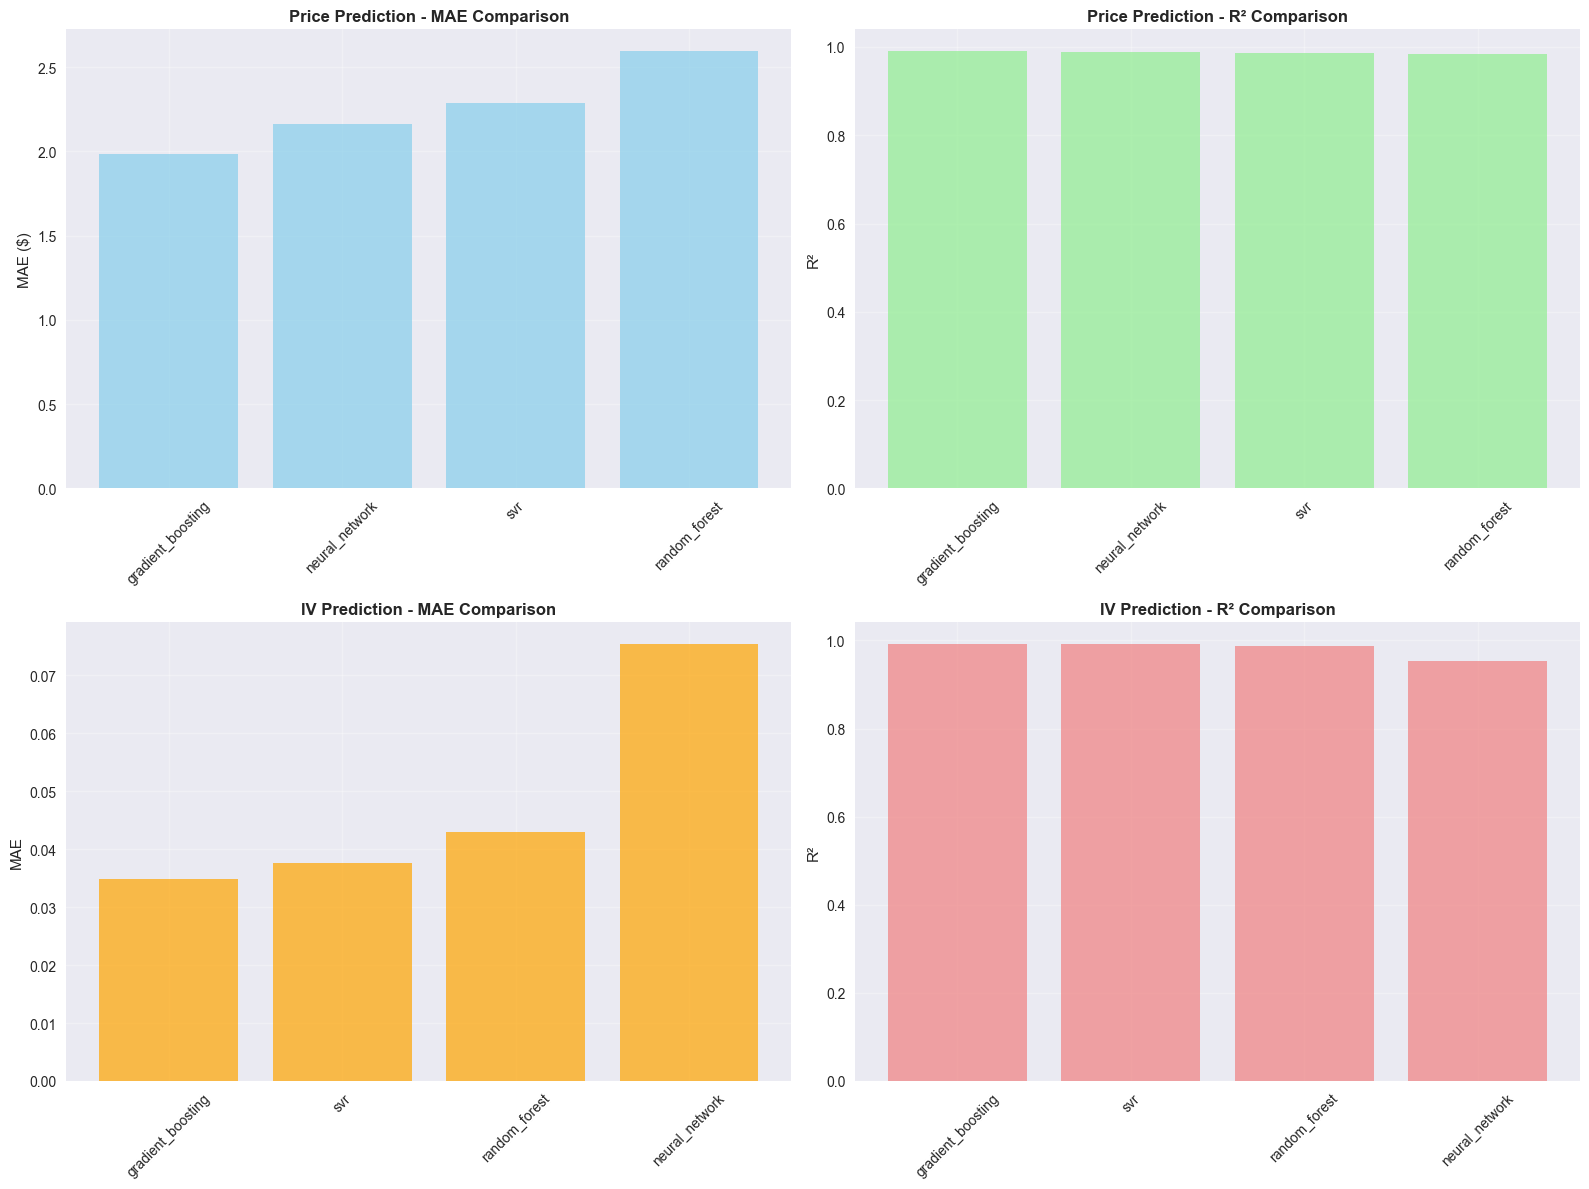

In [13]:
# Plot model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price prediction performance
price_comparison_sorted = price_comparison.sort_values('MAE')
axes[0, 0].bar(price_comparison_sorted['Model'], price_comparison_sorted['MAE'], 
               color='skyblue', alpha=0.7)
axes[0, 0].set_title('Price Prediction - MAE Comparison', fontweight='bold')
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(price_comparison_sorted['Model'], price_comparison_sorted['R²'], 
               color='lightgreen', alpha=0.7)
axes[0, 1].set_title('Price Prediction - R² Comparison', fontweight='bold')
axes[0, 1].set_ylabel('R²')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# IV prediction performance
iv_comparison_sorted = iv_comparison.sort_values('MAE')
axes[1, 0].bar(iv_comparison_sorted['Model'], iv_comparison_sorted['MAE'], 
               color='orange', alpha=0.7)
axes[1, 0].set_title('IV Prediction - MAE Comparison', fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(iv_comparison_sorted['Model'], iv_comparison_sorted['R²'], 
               color='lightcoral', alpha=0.7)
axes[1, 1].set_title('IV Prediction - R² Comparison', fontweight='bold')
axes[1, 1].set_ylabel('R²')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Best Models:
  Price Prediction: gradient_boosting (MAE: $1.9826)
  IV Prediction: gradient_boosting (MAE: 0.0349)


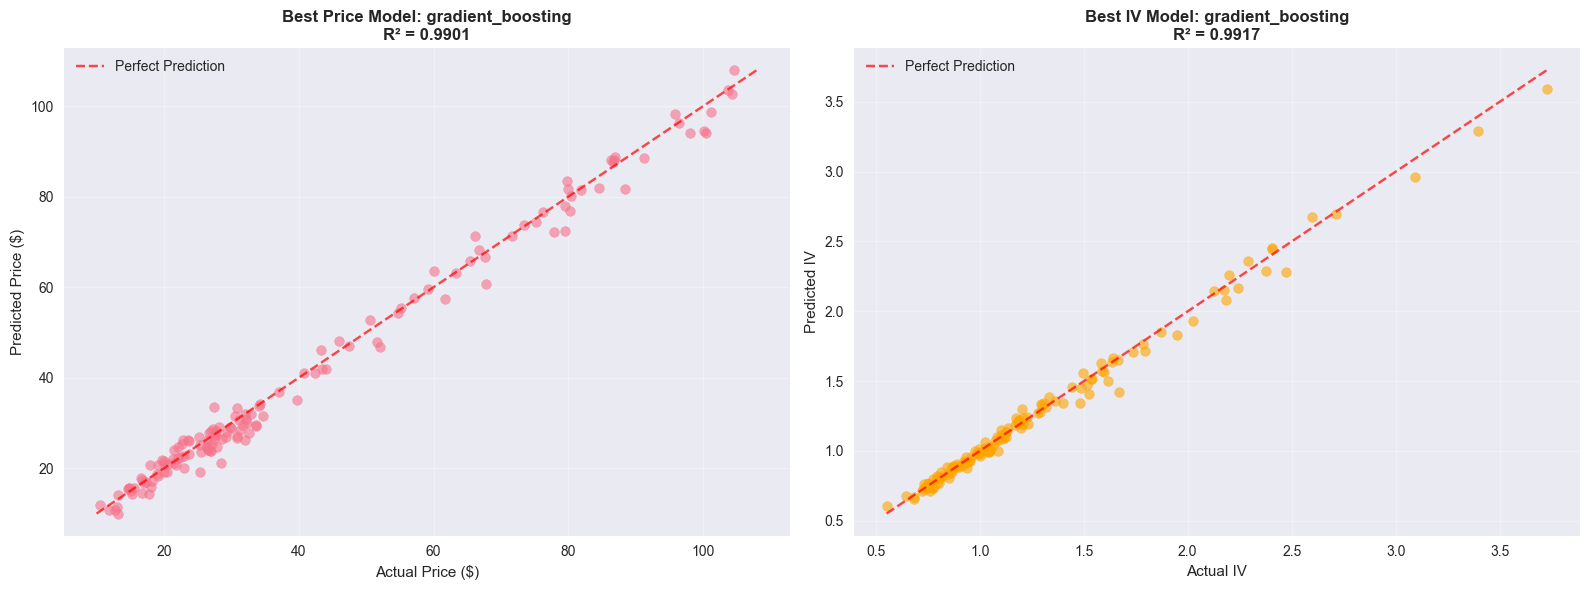

In [14]:
# Plot actual vs predicted for best models
# Find best models
best_price_model = price_comparison.loc[price_comparison['MAE'].idxmin()]
best_iv_model = iv_comparison.loc[iv_comparison['MAE'].idxmin()]

print(f"Best Models:")
print(f"  Price Prediction: {best_price_model['Model']} (MAE: ${best_price_model['MAE']:.4f})")
print(f"  IV Prediction: {best_iv_model['Model']} (MAE: {best_iv_model['MAE']:.4f})")

# Get predictions from best models
best_price_result = next(r for r in price_evaluation_results if r['model_name'] == best_price_model['Model'])
best_iv_result = next(r for r in iv_evaluation_results if r['model_name'] == best_iv_model['Model'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Price prediction scatter
axes[0].scatter(y_price_test, best_price_result['predictions'], alpha=0.6, s=50)
min_price = min(y_price_test.min(), best_price_result['predictions'].min())
max_price = max(y_price_test.max(), best_price_result['predictions'].max())
axes[0].plot([min_price, max_price], [min_price, max_price], 'r--', alpha=0.7, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Best Price Model: {best_price_model["Model"]}\nR² = {best_price_result["r2"]:.4f}', 
                  fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IV prediction scatter
axes[1].scatter(y_iv_test, best_iv_result['predictions'], alpha=0.6, s=50, color='orange')
min_iv = min(y_iv_test.min(), best_iv_result['predictions'].min())
max_iv = max(y_iv_test.max(), best_iv_result['predictions'].max())
axes[1].plot([min_iv, max_iv], [min_iv, max_iv], 'r--', alpha=0.7, label='Perfect Prediction')
axes[1].set_xlabel('Actual IV')
axes[1].set_ylabel('Predicted IV')
axes[1].set_title(f'Best IV Model: {best_iv_model["Model"]}\nR² = {best_iv_result["r2"]:.4f}', 
                  fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Feature Importance Analysis - gradient_boosting (Price Prediction)


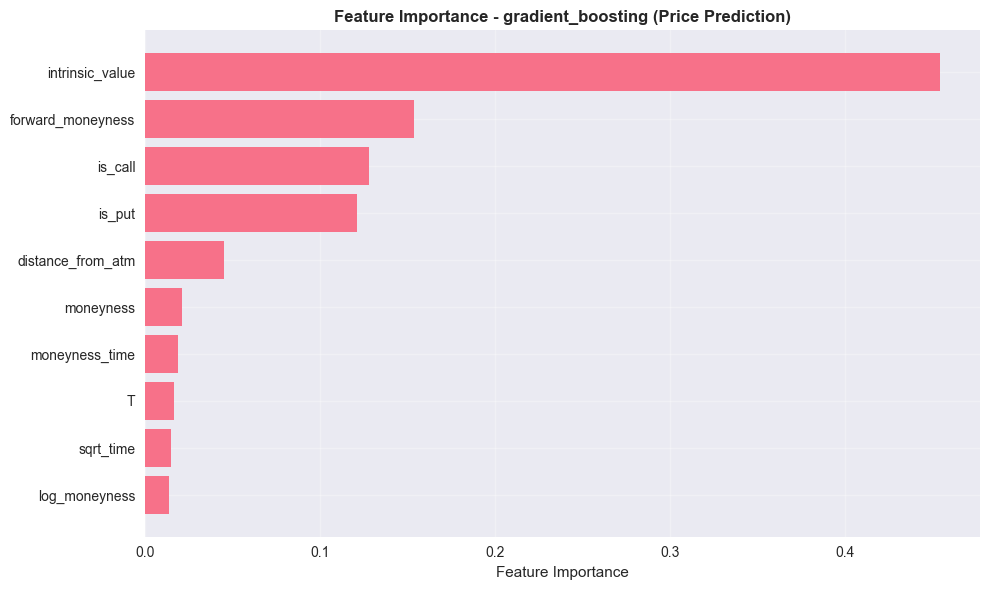


Top 5 Most Important Features (Price Prediction):


,feature,importance
9,intrinsic_value,0.4541
10,forward_moneyness,0.1537
4,is_call,0.1277
5,is_put,0.1213
6,distance_from_atm,0.0451



Feature Importance Analysis - gradient_boosting (IV Prediction)


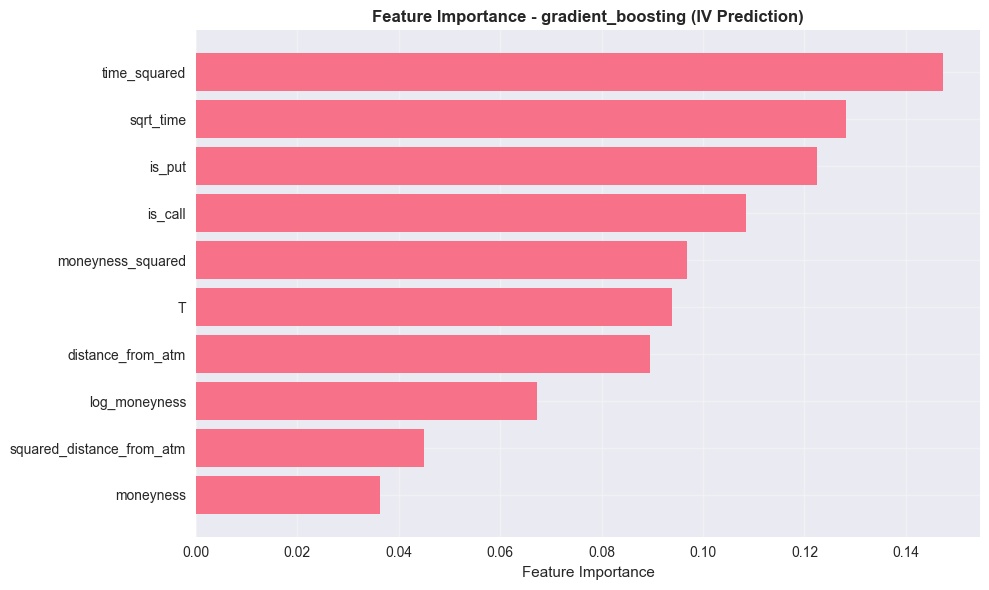


Top 5 Most Important Features (IV Prediction):


,feature,importance
5,time_squared,0.1473
4,sqrt_time,0.1281
7,is_put,0.1225
6,is_call,0.1085
2,moneyness_squared,0.0968


In [15]:
# Analyze feature importance for tree-based models
def plot_feature_importance(model, feature_names, title, top_n=10):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame and sort
        feature_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Plot top features
        plt.figure(figsize=(10, 6))
        top_features = feature_imp.head(top_n)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(title, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return feature_imp
    else:
        print(f"Model {type(model).__name__} does not have feature_importances_ attribute")
        return None

# Feature importance for best price prediction model
if best_price_model['Model'] in ['random_forest', 'gradient_boosting']:
    best_price_clf = price_models[best_price_model['Model']]['model']
    print(f"Feature Importance Analysis - {best_price_model['Model']} (Price Prediction)")
    price_importance = plot_feature_importance(
        best_price_clf, 
        pricing_features, 
        f"Feature Importance - {best_price_model['Model']} (Price Prediction)"
    )
    
    if price_importance is not None:
        print("\nTop 5 Most Important Features (Price Prediction):")
        display(price_importance.head().round(4))

# Feature importance for best IV prediction model
if best_iv_model['Model'] in ['random_forest', 'gradient_boosting']:
    best_iv_clf = iv_models[best_iv_model['Model']]['model']
    print(f"\nFeature Importance Analysis - {best_iv_model['Model']} (IV Prediction)")
    iv_importance = plot_feature_importance(
        best_iv_clf, 
        volatility_features, 
        f"Feature Importance - {best_iv_model['Model']} (IV Prediction)"
    )
    
    if iv_importance is not None:
        print("\nTop 5 Most Important Features (IV Prediction):")
        display(iv_importance.head().round(4))

## 8. Model Persistence and Deployment Preparation

In [16]:
# Save best models for deployment
models_dir = Path('../outputs/models')
models_dir.mkdir(exist_ok=True)

# Save best price prediction model
best_price_model_obj = price_models[best_price_model['Model']]['model']
joblib.dump(best_price_model_obj, models_dir / 'best_price_prediction_model.pkl')

# Save best IV prediction model
best_iv_model_obj = iv_models[best_iv_model['Model']]['model']
joblib.dump(best_iv_model_obj, models_dir / 'best_iv_prediction_model.pkl')

# Save feature lists
import json
with open(models_dir / 'feature_lists.json', 'w') as f:
    json.dump({
        'pricing_features': pricing_features,
        'volatility_features': volatility_features
    }, f, indent=2)

# Save model metadata
model_metadata = {
    'best_price_model': {
        'name': best_price_model['Model'],
        'mae': float(best_price_model['MAE']),
        'rmse': float(best_price_model['RMSE']),
        'r2': float(best_price_model['R²']),
        'mape': float(best_price_model['MAPE'])
    },
    'best_iv_model': {
        'name': best_iv_model['Model'],
        'mae': float(best_iv_model['MAE']),
        'rmse': float(best_iv_model['RMSE']),
        'r2': float(best_iv_model['R²']),
        'mape': float(best_iv_model['MAPE'])
    },
    'training_info': {
        'price_training_samples': len(X_price_train),
        'price_test_samples': len(X_price_test),
        'iv_training_samples': len(X_iv_train),
        'iv_test_samples': len(X_iv_test),
        'features_count_pricing': len(pricing_features),
        'features_count_iv': len(volatility_features)
    }
}

with open(models_dir / 'ml_models_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2, default=str)

print(f"Models saved to {models_dir}:")
print(f"  • best_price_prediction_model.pkl")
print(f"  • best_iv_prediction_model.pkl")
print(f"  • feature_lists.json")
print(f"  • ml_models_metadata.json")

Models saved to ../outputs/models:
  • best_price_prediction_model.pkl
  • best_iv_prediction_model.pkl
  • feature_lists.json
  • ml_models_metadata.json


In [17]:
# Create comprehensive results summary
ml_summary = {
    'training_completed': True,
    'models_trained': {
        'price_prediction': list(price_models.keys()),
        'iv_prediction': list(iv_models.keys())
    },
    'best_models': {
        'price_prediction': {
            'model': best_price_model['Model'],
            'performance': {
                'mae': float(best_price_model['MAE']),
                'rmse': float(best_price_model['RMSE']),
                'r2': float(best_price_model['R²']),
                'mape': float(best_price_model['MAPE'])
            }
        },
        'iv_prediction': {
            'model': best_iv_model['Model'],
            'performance': {
                'mae': float(best_iv_model['MAE']),
                'rmse': float(best_iv_model['RMSE']),
                'r2': float(best_iv_model['R²']),
                'mape': float(best_iv_model['MAPE'])
            }
        }
    },
    'all_model_performance': {
        'price_prediction': price_comparison.to_dict('records'),
        'iv_prediction': iv_comparison.to_dict('records')
    }
}

# Save complete results
results_dir = Path('../outputs/results')
with open(results_dir / 'ml_training_results.json', 'w') as f:
    json.dump(ml_summary, f, indent=2, default=str)

print(f"\nComplete ML training results saved to:")
print(f"  • {results_dir}/ml_training_results.json")

print(f"\nML TRAINING SUMMARY")
print(f"=" * 50)
print(f"✅ Successfully trained {len(price_models)} price prediction models")
print(f"✅ Successfully trained {len(iv_models)} IV prediction models")
print(f"\n🏆 BEST MODELS:")
print(f"  Price Prediction: {best_price_model['Model']} (MAE: ${best_price_model['MAE']:.4f}, R²: {best_price_model['R²']:.4f})")
print(f"  IV Prediction: {best_iv_model['Model']} (MAE: {best_iv_model['MAE']:.4f}, R²: {best_iv_model['R²']:.4f})")
print(f"\n💾 Models saved and ready for deployment")
print(f"\n➡️  Next: Model evaluation and comparison notebook")


Complete ML training results saved to:
  • ../outputs/results/ml_training_results.json

ML TRAINING SUMMARY
✅ Successfully trained 4 price prediction models
✅ Successfully trained 4 IV prediction models

🏆 BEST MODELS:
  Price Prediction: gradient_boosting (MAE: $1.9826, R²: 0.9901)
  IV Prediction: gradient_boosting (MAE: 0.0349, R²: 0.9917)

💾 Models saved and ready for deployment

➡️  Next: Model evaluation and comparison notebook
